In [1]:
import numpy as np
import pandas as pd
import string
import pymorphy2
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from scipy import sparse

from sklearn.metrics import f1_score

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

test_df.shape

(165378, 3)

Смотрим на гистограммы распределения количества слов в заголовке

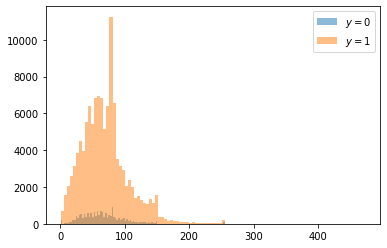

In [3]:
len1 = train_df.loc[train_df['target'] == True, 'title'].str.len().values
len2 = train_df.loc[train_df['target'] == False, 'title'].str.len().values
bins=100
alpha=0.5

plt.hist(len1, alpha=alpha, bins=bins, label=r'$y = 0$')
plt.hist(len2, alpha=alpha, bins=bins, label=r'$y = 1$')
plt.legend();

Убираем дублирующиеся строки, убираем пунктуацию и символы

In [4]:
train_df = train_df.drop_duplicates()

train_df_cl = train_df.copy()
test_df_cl = test_df.copy()

train_df_cl["title"] = train_df_cl["title"].astype(str)
test_df_cl["title"] = test_df_cl["title"].astype(str)

train_df_cl["title"] = train_df_cl["title"].str.lower()
test_df_cl["title"] = test_df_cl["title"].str.lower()

PUNCT_TO_REMOVE = string.punctuation + '1234567890«»—�'
def remove_punctuation(text):
    return text.translate(str.maketrans(PUNCT_TO_REMOVE, ' '*len(PUNCT_TO_REMOVE)))

train_df_cl["title"] = train_df_cl["title"].apply(lambda text: remove_punctuation(text))
test_df_cl["title"] = test_df_cl["title"].apply(lambda text: remove_punctuation(text))


Убираем наблюдения с малым количеством символов

In [5]:
train_df_cl = train_df_cl.loc[train_df_cl['title'].str.split().str.len() > 2]

train_df_cl.shape

(128845, 4)

Удаляем стоп слова

In [6]:
mystopwords = stopwords.words('russian') + stopwords.words('english')

def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
train_df_cl.title = train_df_cl.title.apply(remove_stopwords)
test_df_cl.title = test_df_cl.title.apply(remove_stopwords)
train_df_cl.head()

,id,url,title,target
0,0,m.kp.md,экс министр экономики молдовы главе мидэи цель...,False
1,1,www.kp.by,эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,банши сезон серия бремя красоты смотреть онлайн,False
3,3,colorbox.spb.ru,беси картинки,False
4,4,tula-sport.ru,новомосковске сыграют следж хоккеисты алексинс...,False


Лемматизируем русские слова

In [7]:
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}
def lem_text(text):
    return ' '.join([lem_token(token) for token in text.split()])

def lem_token(token):
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

train_df_cl.title = train_df_cl.title.apply(lem_text)
test_df_cl.title = test_df_cl.title.apply(lem_text)

Разделяем url по точке

In [8]:
def split_url(text):
    return ' '.join(text.split('.'))

train_df_cl.url = train_df_cl.url.apply(split_url)
test_df_cl.url = test_df_cl.url.apply(split_url)

In [9]:
X_train_title = train_df_cl["title"].values
X_train_url = train_df_cl["url"].values
X_test_title = test_df_cl["title"].values
X_test_url = test_df_cl["url"].values
y_train = train_df_cl["target"].astype(int).values

# ML baseline

In [16]:
# Инициализируем векторизаторы для заголовка и url
vectorizer1 = CountVectorizer(ngram_range=(1,2), min_df=2, binary=True)
vectorizer2 = CountVectorizer(ngram_range=(1,3), min_df=2, binary=False, analyzer='char')

# Инициализируем логистическую регрессию
model1 = LogisticRegression(max_iter=500, solver='liblinear', class_weight='balanced',C = 100)

Разделяем тренировочный сет и векторизуем 

In [17]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train_title, y_train, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_url, y_train, test_size=0.3, random_state=42)

X_train1_vectorized = vectorizer1.fit_transform(X_train1)
X_train2_vectorized = vectorizer2.fit_transform(X_train2)

X_train_vectorized = hstack([X_train1_vectorized, X_train2_vectorized])

X_test1_vectorized = vectorizer1.transform(X_test1)
X_test2_vectorized = vectorizer2.transform(X_test2)

X_test_vectorized = hstack([X_test1_vectorized, X_test2_vectorized])

X_test1_vectorized_sub = vectorizer1.transform(X_test_title)
X_test2_vectorized_sub = vectorizer2.transform(X_test_url)

X_test_vectorized_sub = hstack([X_test1_vectorized_sub, X_test2_vectorized_sub])

Фитируем логистическую регрессию

In [18]:
%%time

model1.fit(
    X_train_vectorized,
    y_train1
)

y_pred = model1.predict(
    X_test_vectorized
)
f1_score(y_test1, y_pred)

Wall time: 4.11 s


0.980521488199526

Определяем классификаторы для голосования

In [19]:
RF = RandomForestClassifier(n_estimators=30, n_jobs=-1, bootstrap=True,
                            warm_start=False, max_features='auto', criterion='entropy',
                           min_samples_split=2, min_samples_leaf=1, random_state=32, class_weight='balanced')
LGBM = LGBMClassifier(learning_rate=0.08, n_estimators=100)
SGD = SGDClassifier(class_weight='balanced')

# ГОЛОСОВАНИЕ!
добавляем в качестве признака пробу логистической регрессии

In [20]:
VC = VotingClassifier(estimators=[
    ('SGDC', SGD), ('rf', RF), ('LGBM', LGBM)], voting='hard')

VC.fit(
    hstack([X_train_vectorized, model1.predict_proba(X_train_vectorized)]).astype(np.float32),
    y_train1
)

y_pred = VC.predict(
    hstack([X_test_vectorized, model1.predict_proba(X_test_vectorized)]).astype(np.float32)
)
print(f1_score(y_test1, y_pred))

y_pred = VC.predict(
    hstack([X_train_vectorized, model1.predict_proba(X_train_vectorized)]).astype(np.float32)
)
f1_score(y_train1, y_pred)

c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\lightgbm\basic.py:597: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


0.9805794994288088


0.9997822015071656

### Submit

In [89]:
test_df["target"] = VC.predict(hstack([X_test_vectorized_sub, model1.predict_proba(X_test_vectorized_sub)])).astype(bool)

test_df[["id", "target"]].to_csv("ml_baseline.csv", index=False)